
# Correlation Analysis: Dynatrace Alerts vs ETA Logs

This notebook analyzes the correlation between Dynatrace problem alerts and ETA transaction logs.

### Steps:
1. Load ETA logs from `cleaned_eta_logs.csv`
2. Convert alert timestamps from epoch to human-readable datetime
3. Aggregate ETA logs by minute and count slow transactions
4. Visualize slow transaction trends with alert markers
5. Generate correlation summary for each alert window


In [29]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from datetime import datetime
import json

# Configure Plotly for Jupyter
pyo.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "notebook"

In [30]:
# Load ETA logs
eta_logs = pd.read_csv('datasets/cleaned_eta_logs.csv')
eta_logs['datetime'] = pd.to_datetime(eta_logs['datetime'])
eta_logs.head()


,datetime,agent_type,pid,transaction_id,execution_time,source_file,line_number,date,hour,minute,is_slow,is_very_slow,is_critical
0,2025-11-06 00:00:00.850,eta_agent,7964,11017737610524,4.121,time6.txt,82537,2025-11-06,0,0,False,False,False
1,2025-11-06 00:00:04.978,eta_agent,7773,11017737601406,0.099,time6.txt,44569,2025-11-06,0,0,False,False,False
2,2025-11-06 00:00:05.251,eta_agent,7690,11017737607061,10.955,time6.txt,1,2025-11-06,0,0,False,False,False
3,2025-11-06 00:00:05.782,eta_agent,8144,11017737599261,3.988,time6.txt,128222,2025-11-06,0,0,False,False,False
4,2025-11-06 00:00:05.995,eta_agent,7771,11017737599253,4.455,time6.txt,40181,2025-11-06,0,0,False,False,False


In [31]:

# Define problem alerts from provided JSON
problem_json_list = [
    {"problemId":"1000724463514535050_1762455660000V2","title":"AppGW-Borders Gov - SA - Slowness","status":"OPEN","startTime":1762455660000,"endTime":-1},
    {"problemId":"-1349479328943597503_1762456020000V2","title":"AppGW-Borders Gov - SA - Slowness","status":"CLOSED","startTime":1762456020000,"endTime":1762466460000},
    {"problemId":"6509037658883742559_1762466400000V2","title":"Multiple environment problems","status":"CLOSED","startTime":1762466580000,"endTime":1762467660000},
    {"problemId":"-167381760208408038_1762468320000V2","title":"AppGW-Borders Gov - SA - Slowness","status":"CLOSED","startTime":1762468440000,"endTime":1762468620000}
]

# Convert epoch to datetime
for alert in problem_json_list:
    alert['start_dt'] = datetime.fromtimestamp(alert['startTime']/1000)
    alert['end_dt'] = None if alert['endTime'] == -1 else datetime.fromtimestamp(alert['endTime']/1000)
problem_json_list


[{'problemId': '1000724463514535050_1762455660000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'OPEN',
  'startTime': 1762455660000,
  'endTime': -1,
  'start_dt': datetime.datetime(2025, 11, 6, 22, 1),
  'end_dt': None},
 {'problemId': '-1349479328943597503_1762456020000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'CLOSED',
  'startTime': 1762456020000,
  'endTime': 1762466460000,
  'start_dt': datetime.datetime(2025, 11, 6, 22, 7),
  'end_dt': datetime.datetime(2025, 11, 7, 1, 1)},
 {'problemId': '6509037658883742559_1762466400000V2',
  'title': 'Multiple environment problems',
  'status': 'CLOSED',
  'startTime': 1762466580000,
  'endTime': 1762467660000,
  'start_dt': datetime.datetime(2025, 11, 7, 1, 3),
  'end_dt': datetime.datetime(2025, 11, 7, 1, 21)},
 {'problemId': '-167381760208408038_1762468320000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'CLOSED',
  'startTime': 1762468440000,
  'endTime': 1762468620000,
  'start

In [32]:

# Aggregate ETA logs by minute and count slow transactions
eta_logs['minute_bucket'] = eta_logs['datetime'].dt.floor('min')
slow_counts = eta_logs.groupby('minute_bucket')['is_slow'].sum().reset_index()
slow_counts.rename(columns={'is_slow':'slow_txn_count'}, inplace=True)

# Save as csv  
slow_counts.to_csv('slow_counts.csv', index=False)
print('Saved -> slow_counts.csv')

slow_counts.head()


Saved -> slow_counts.csv


,minute_bucket,slow_txn_count
0,2025-11-06 00:00:00,0
1,2025-11-06 00:01:00,0
2,2025-11-06 00:02:00,0
3,2025-11-06 00:03:00,0
4,2025-11-06 00:04:00,0


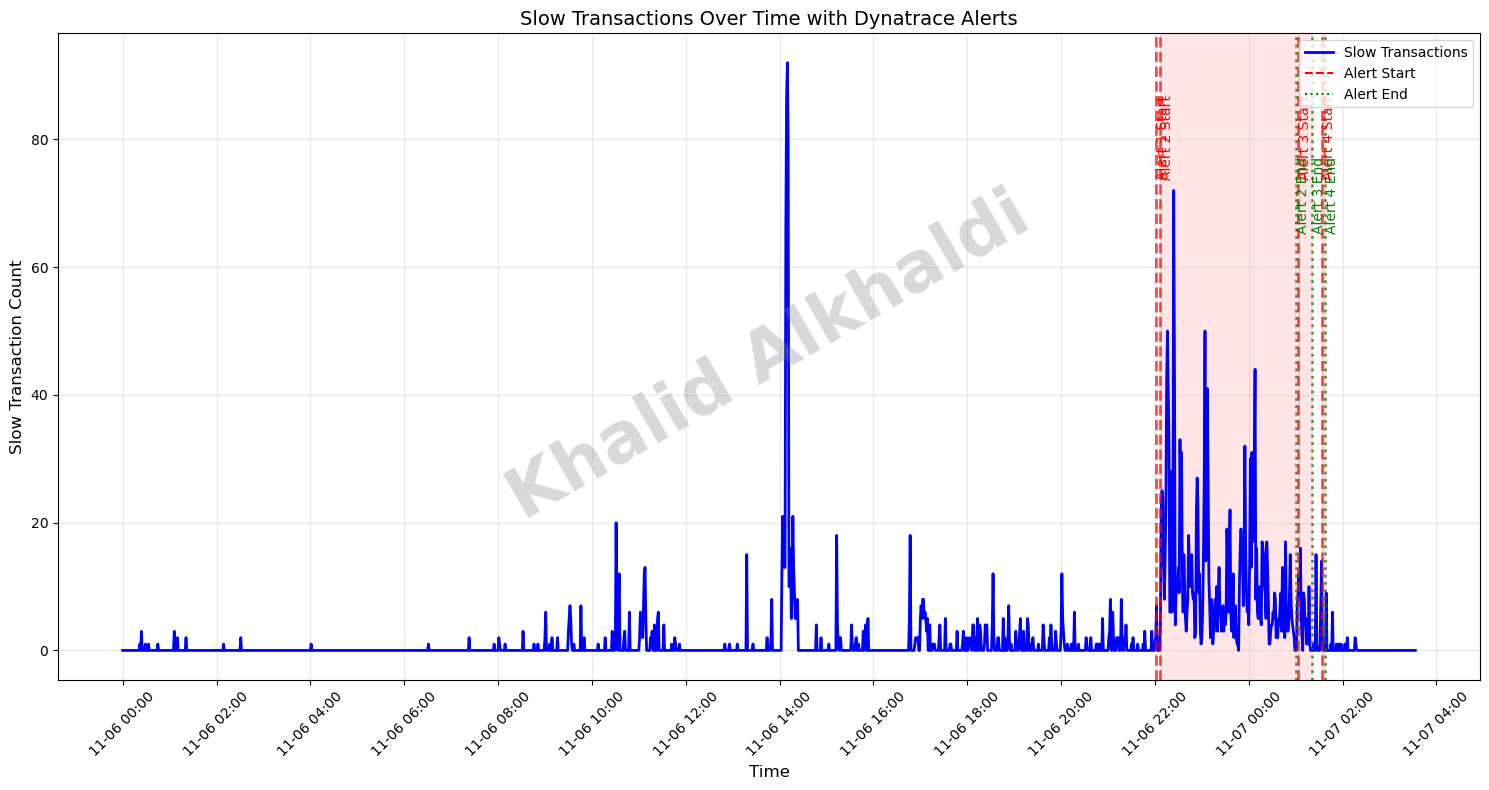

Saved -> slow_transactions_with_dynatrace.png


In [42]:
# Create timeline chart using matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the slow transaction counts
ax.plot(slow_counts['minute_bucket'], slow_counts['slow_txn_count'], 
        linewidth=2, color='blue', label='Slow Transactions')

# Add alert markers
for i, alert in enumerate(problem_json_list):
    # Reset to original timestamps
    alert['start_dt'] = datetime.fromtimestamp(alert['startTime']/1000)
    alert['end_dt'] = None if alert['endTime'] == -1 else datetime.fromtimestamp(alert['endTime']/1000)
    
    # Add vertical line for alert start
    ax.axvline(x=alert['start_dt'], color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add text annotation for alert start
    ax.text(alert['start_dt'], ax.get_ylim()[1] * 0.9, f'Alert {i+1} Start', 
            rotation=90, verticalalignment='top', color='red', fontsize=10)
    
    # Add alert end if it exists
    if alert['end_dt']:
        ax.axvline(x=alert['end_dt'], color='green', linestyle=':', linewidth=2, alpha=0.7)
        ax.text(alert['end_dt'], ax.get_ylim()[1] * 0.8, f'Alert {i+1} End', 
                rotation=90, verticalalignment='top', color='green', fontsize=10)
        
        # Shade the alert duration
        ax.axvspan(alert['start_dt'], alert['end_dt'], alpha=0.1, color='red')

# Add watermark
ax.text(0.5, 0.5, 'Khalid Alkhaldi', 
        transform=ax.transAxes, fontsize=50, color='gray', alpha=0.3,
        ha='center', va='center', rotation=30, weight='bold')

# Formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Slow Transaction Count', fontsize=12)
ax.set_title('Slow Transactions Over Time with Dynatrace Alerts', fontsize=14)
ax.grid(True, alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Slow Transactions'),
    Line2D([0], [0], color='red', linestyle='--', label='Alert Start'),
    Line2D([0], [0], color='green', linestyle=':', label='Alert End')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Save for slides
fig.savefig('slow_transactions_with_dynatrace.png', dpi=160)
print("Saved -> slow_transactions_with_dynatrace.png")

In [34]:

# Generate correlation summary
summary = []
for alert in problem_json_list:
    window_start = alert['start_dt']
    window_end = alert['end_dt'] if alert['end_dt'] else window_start + pd.Timedelta(minutes=30)
    window_data = slow_counts[(slow_counts['minute_bucket'] >= window_start) & (slow_counts['minute_bucket'] <= window_end)]
    avg_slow = window_data['slow_txn_count'].mean() if not window_data.empty else 0
    summary.append({
        'problemId': alert['problemId'],
        'title': alert['title'],
        'status': alert['status'],
        'start': str(window_start),
        'end': str(window_end),
        'avg_slow_txn_count': avg_slow
    })

summary


[{'problemId': '1000724463514535050_1762455660000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'OPEN',
  'start': '2025-11-06 22:01:00',
  'end': '2025-11-06 22:31:00',
  'avg_slow_txn_count': np.float64(17.548387096774192)},
 {'problemId': '-1349479328943597503_1762456020000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'CLOSED',
  'start': '2025-11-06 22:07:00',
  'end': '2025-11-07 01:01:00',
  'avg_slow_txn_count': np.float64(11.942857142857143)},
 {'problemId': '6509037658883742559_1762466400000V2',
  'title': 'Multiple environment problems',
  'status': 'CLOSED',
  'start': '2025-11-07 01:03:00',
  'end': '2025-11-07 01:21:00',
  'avg_slow_txn_count': np.float64(4.947368421052632)},
 {'problemId': '-167381760208408038_1762468320000V2',
  'title': 'AppGW-Borders Gov - SA - Slowness',
  'status': 'CLOSED',
  'start': '2025-11-07 01:34:00',
  'end': '2025-11-07 01:37:00',
  'avg_slow_txn_count': np.float64(0.5)}]